## Experimenting with graphframe and pyspark

I tend to follow the User guide for Graphframe and that is posted on Databricks https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html. 

In [1]:
from src.GHnet import *
from src.parse_edges import *

Now, read the fork edges and the contribution edges from the text file `fork_edges.txt` and `contrib_edges.txt`. For each line in the two files, the edges will be in the form of a tuple `(u,r)` or `(r,u)`. Here `r` and `u` specifies the repositories ID and user ID on GitHub. For more information about the storage formats of `fork_edges.txt` and `contrib_edges.txt`. and how edges are collected (and how the network is formed), please consult the meta file `meta.md`. 

After we read in the contribution edges and fork edges, we will build the Biparitite Graph using Graphframe. Now, we will convert the text file that contains the edges into two parquet file `vertices.parquet` and `edges.parquet`. 

In [5]:
txt_to_pq(contrib_edge_file='data/contrib_edges.txt',
          fork_edge_file='data/fork_edges.txt')

Next, using these two parquet file, we will construct a graphframe object. 

In [2]:
demo = GHnet(vertices_pq='data/vertices.parquet',
            edges_pq='data/edges.parquet')

## Preliminary EDA on the Graph
After we create a graphframe object, we can now do some preliminary EDA on the graph. One straightfoward thing we can check is the in and out degree distribution of the users and repos. 

/home/rgan/s651/651_Project/src/GHnet.py:77: RuntimeWarning: divide by zero encountered in log
  np.log([1 - i for i in samp_probs]),


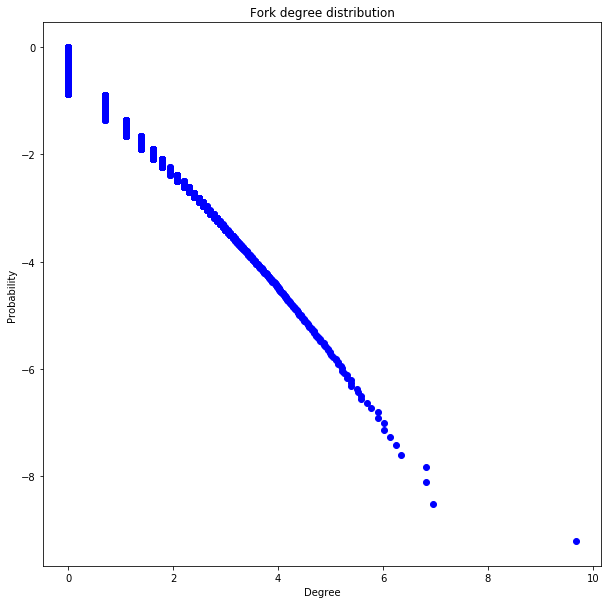

In [4]:
a = demo.degree_dist(deg_type='f', plot = True)

## Page Rank of GitHub's repository and users
Top ten influential repository?

## Community Detection

### LPAb
This is the implementation of LPAb+ algorithm for label propagation in a bipartite network. LPA is an efficient algorithm for community detectionm, as for each iteration every node send out its label to its neighboring nodes. And every nodes will then update its label to the most frequent label received at each iteration. Label will be randomly decided if there are ties in the counts of labels. LPA is efficient. However, it doesn't gurantee convergence. Particularly, a phenomenon called label oscillation will occur if there is a bipartite compoenent in the graph. 

To overcome, we will consider an invariant from of LPA, which is called LPAb (b stands for bipartite). A small but major difference between 'vanila' LPA and LPAb is in the orders that the labels are updated. Before the iteration, we will first assign two colors (red and blue) to the two types of nodes in the bipartite network. WLOG, assume we assign unique labels to the red nodes while not assigning blue nodes any label. Then in the first iteration, red nodes are then updated by the most frequent node labels. 

In GitHub's fork-contribution network (where the edges are directed), we will first assign the users with their own unique labels. Then in the next iteration, the users will send out their current label to their contributing repos and these repos will update their labels to the most popular label. In the second iteration, the users who fork from the repos will receive the updated labels from the repos. Such alternating updating scheme will carry on until there is no labeling changes for any node in the graph or after some specificed number of iterations.

After seeing the LPAb, we will continue to a more complicated LPA, which involves the concept of modularity. Modularity is a measure of community cohesion of a networks. Given the label vector $Z$ where its $i$-th entry is the labeling assignment of node $i$ the defination of modularity for directed graph is given by $$Q = \frac{c}{f+c}\sum_{u,r}\big[A_{ur} - \frac{k_u^{in}k_r^{out}}{c}\big]\delta(Z_u, Z_r) + \frac{f}{f+c}\sum_{u,r}\big[A_{ru} - \frac{k_r^{in}k_u^{out}}{f}\big]\delta(Z_u, Z_r)$$, where $f$ is the number of fork edges and contribution, $k_i^{in}, k_i^{out}$ are the in and out degree of node $i$, and $\delta$ is the kronecker delta. A community partition will have a high modularity if connected nodes tend to share the same label. 

Now, we will introduce an algorithm called LPAb+, which incorporates the above idea in the updating and stropping rule of the algorithm. It involves one bottom-up steps and top-down step.

In [3]:
initLabelUDF = F.udf(lambda i, j: i if j == 1 else None,
                              types.IntegerType())
v = demo.gf.vertices.withColumn('label', initLabelUDF(F.col('id'), F.col('nodeType')))

In [4]:
test = GraphFrame(v, demo.gf.edges)

In [ ]:
a = GHnet.Modularity(test)

/home/rgan/anaconda3/lib/python3.7/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


# (If Time allows) Matrix completion problem
We now observe a bipartite contribution-fork network. But we know that users on GitHub collaborate with each other (or they can follow someone they look up to) and repos depends on other repos as well (unless developers enjoy torturing themselves or tired of being tortured by shitty packages they use on a daily basis). We can think of this as a matrix completion problem, where we want to fill in the unobserved entries in our population adjacency matrix. Suppose we have a small sample of collaboration/follower and repository dependency information, can we use that to complete our population graph?

In [2]:
from itertools import product
[a for a in product([1,2,3], [4,5,6])]

[(1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]

In [3]:
{k:k[0]*k[1] for k in [k for k in product([1,2,3], [4,5,6])]}

{(1, 4): 4,
 (1, 5): 5,
 (1, 6): 6,
 (2, 4): 8,
 (2, 5): 10,
 (2, 6): 12,
 (3, 4): 12,
 (3, 5): 15,
 (3, 6): 18}

In [14]:
a = [(x,y, z) for (x, y, z) in zip([1,2,3], [1,3,4], [1,2,3])]

In [17]:
import pandas as pd
b = pd.DataFrame(a, columns = ['x', 'y', 'z'])
c = pd.DataFrame(a, columns = ['x', 'y', 'z'])

In [19]:
[d for d in product(b['x'], c['x'])]

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]